# 💻 Laptop Sales Prediction & Analysis Dashboard
# Professional Data Science & Predictive Analytics Project

# Import Required Libraries

# 📋 Table of Contents (Navigation)
# 1. Introduction & Data Loading
# 2. Data Preparation & Cleaning
# 3. Exploratory Data Analysis
# 4. Feature Engineering
# 5. Predictive Modeling
# 6. Model Evaluation
# 7. Interactive Dashboard
# 8. Business Insights & Recommendations
```

# 📌 1. Introduction
# This professional notebook provides a comprehensive analysis of the laptop market 
# using the Cleaned_Laptop_data.csv dataset. We'll explore pricing trends, specifications,
# customer ratings, and build predictive models to forecast laptop sales and pricing strategies.

# Business Objectives:
# - Identify key factors driving laptop sales and pricing
# - Develop accurate predictive models for price optimization
# - Generate actionable business insights for inventory management
# - Create interactive visualizations for stakeholder presentations

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings


# Configuration settings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

# Set custom styles for better visualizations
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set(style="whitegrid")

In [11]:
# Load the dataset
file_path = '/kaggle/input/laptops-cleaned-dataset/laptops cleaned.csv'  # Update path if needed
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset Dimensions: {df.shape[0]} rows and {df.shape[1]} columns")
print("\nDataset Summary:")
df.info()

# Display first five rows with improved styling
df.head()

Dataset Dimensions: 1271 rows and 21 columns

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1271 non-null   int64  
 1   Company            1271 non-null   object 
 2   TypeName           1271 non-null   object 
 3   Inches             1271 non-null   float64
 4   screen_resolution  893 non-null    object 
 5   has_ips_panel      1271 non-null   int64  
 6   is_touchscreen     1271 non-null   int64  
 7   resolution_width   1271 non-null   int64  
 8   resolution_height  1271 non-null   int64  
 9   cpu_brand          1271 non-null   object 
 10  cpu_name           1271 non-null   object 
 11  cpu_speed          1271 non-null   float64
 12  Ram                1271 non-null   int64  
 13  memory_type        1260 non-null   object 
 14  primary_storage    1271 non-null   int64  
 15  secondary

,index,Company,TypeName,Inches,screen_resolution,has_ips_panel,is_touchscreen,resolution_width,resolution_height,cpu_brand,...,cpu_speed,Ram,memory_type,primary_storage,secondary_storage,gpu_brand,gpu_name,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,NaN,1,0,1600,2560,Intel,...,2.3,8,SSD,128,0,Intel,Iris Plus Graphics 640,macos,1.4,71379
1,1,Apple,Ultrabook,13.3,NaN,0,0,900,1440,Intel,...,1.8,8,Flash Storage,128,0,Intel,HD Graphics 6000,macos,1.3,47896
2,2,HP,Notebook,15.6,Full HD,0,0,1080,1920,Intel,...,2.5,8,SSD,256,0,Intel,HD Graphics 620,NaN,1.9,30636
3,3,Apple,Ultrabook,15.4,NaN,1,0,1800,2880,Intel,...,2.7,16,SSD,512,0,AMD,Radeon Pro 455,macos,1.8,135195
4,4,Apple,Ultrabook,13.3,NaN,1,0,1600,2560,Intel,...,3.1,8,SSD,256,0,Intel,Iris Plus Graphics 650,macos,1.4,96096


# 📂 2. Data Preparation & Cleaning

In [12]:
# Comprehensive data quality check
def data_quality_report(df):
    # Missing values analysis
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    # Duplicates check
    duplicates = df.duplicated().sum()
    
    # Data types
    data_types = df.dtypes
    
    # Statistical summary for numerical columns
    numerical_summary = df.describe().T
    
    # Unique values for categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    unique_values = {col: df[col].nunique() for col in categorical_cols}
     # Print report
    print("="*80)
    print("DATA QUALITY REPORT")
    print("="*80)
    print(f"\nTotal Rows: {df.shape[0]}, Total Columns: {df.shape[1]}")
    print(f"Duplicate Rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")
    
    print("\nMISSING VALUES:")
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Count': missing_values.values,
        'Missing Percentage': missing_percentage.values
    }).sort_values('Missing Count', ascending=False)
    display(missing_df[missing_df['Missing Count'] > 0])
    
    print("\nDATA TYPES:")
    display(pd.DataFrame({'Column': data_types.index, 'Data Type': data_types.values}))
    
    print("\nUNIQUE VALUES (CATEGORICAL):")
    display(pd.DataFrame({'Column': unique_values.keys(), 'Unique Count': unique_values.values()}))
    
    return missing_df, numerical_summary

# Data Cleaning and Preprocessing
# Create a copy of the original dataframe
df_clean = df.copy()
# Reset index
df_clean.reset_index(drop=True, inplace=True)

# Display sample of cleaned data
print("\nSample of Cleaned Data:")
df_clean.head()

# Generate data quality report
missing_data, numerical_stats = data_quality_report(df)

# Handle missing values
if 'display_size' in df_clean.columns and df_clean['display_size'].isnull().sum() > 0:
    # Impute missing display sizes with the mode or median
    df_clean['display_size'] = df_clean['display_size'].fillna(df_clean['display_size'].mode()[0])

# Clean and convert numeric columns
numeric_cols = ['ram_gb', 'ssd', 'hdd', 'latest_price', 'old_price', 'discount']
for col in numeric_cols:
    if col in df_clean.columns:
        # Remove non-numeric characters and convert to numeric
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.extract('(\d+)').astype(float)

# Drop duplicates
df_clean = df_clean.drop_duplicates()


Sample of Cleaned Data:
DATA QUALITY REPORT

Total Rows: 1271, Total Columns: 21
Duplicate Rows: 0 (0.00%)

MISSING VALUES:


,Column,Missing Count,Missing Percentage
4,screen_resolution,378,29.740362
18,OpSys,63,4.956727
13,memory_type,11,0.865460



DATA TYPES:


,Column,Data Type
0,index,int64
1,Company,object
2,TypeName,object
3,Inches,float64
4,screen_resolution,object
5,has_ips_panel,int64
6,is_touchscreen,int64
7,resolution_width,int64
8,resolution_height,int64
9,cpu_brand,object



UNIQUE VALUES (CATEGORICAL):


,Column,Unique Count
0,Company,19
1,TypeName,6
2,screen_resolution,3
3,cpu_brand,3
4,cpu_name,40
5,memory_type,4
6,gpu_brand,4
7,gpu_name,110
8,OpSys,4


# 🔍 3. Exploratory Data Analysis

# 3.1 Price Distribution Analysis

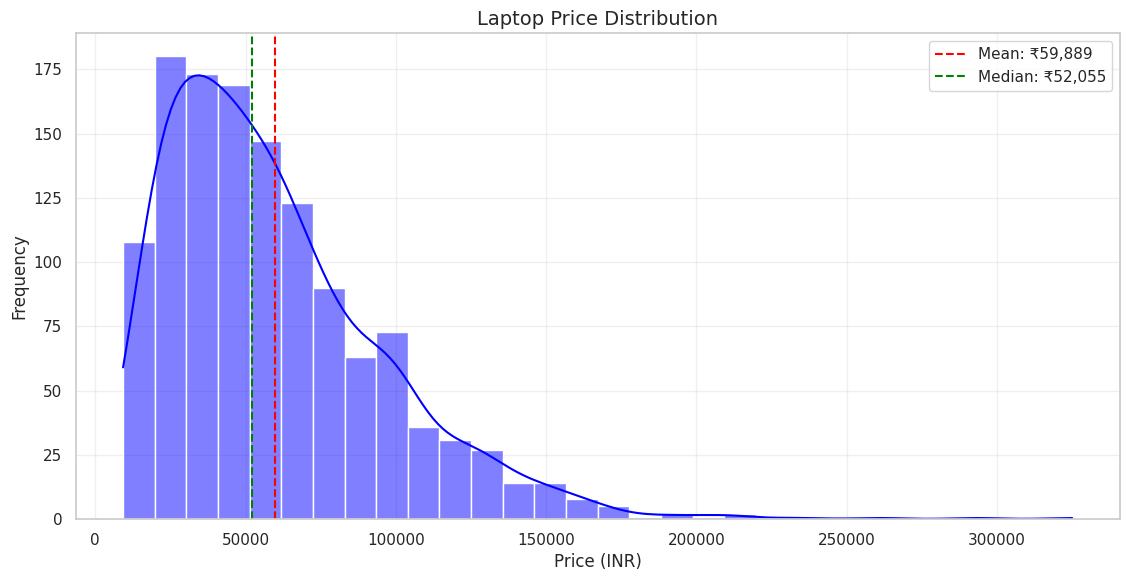

In [13]:
plt.figure(figsize=(12, 6))

# Change 'latest_price' to whatever your price column is actually named
price_column = 'Price'  # Update this to match your actual price column

# Create the histogram
sns.histplot(df_clean[price_column], bins=30, kde=True, color='blue')

# Add mean and median lines with appropriate currency symbol (₹ for Indian Rupees)
plt.axvline(df_clean[price_column].mean(), color='red', linestyle='--', 
            label=f'Mean: ₹{df_clean[price_column].mean():,.0f}')
plt.axvline(df_clean[price_column].median(), color='green', linestyle='--', 
            label=f'Median: ₹{df_clean[price_column].median():,.0f}')

# Labels and title
plt.xlabel('Price (INR)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Laptop Price Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3.2 Brand Analysis

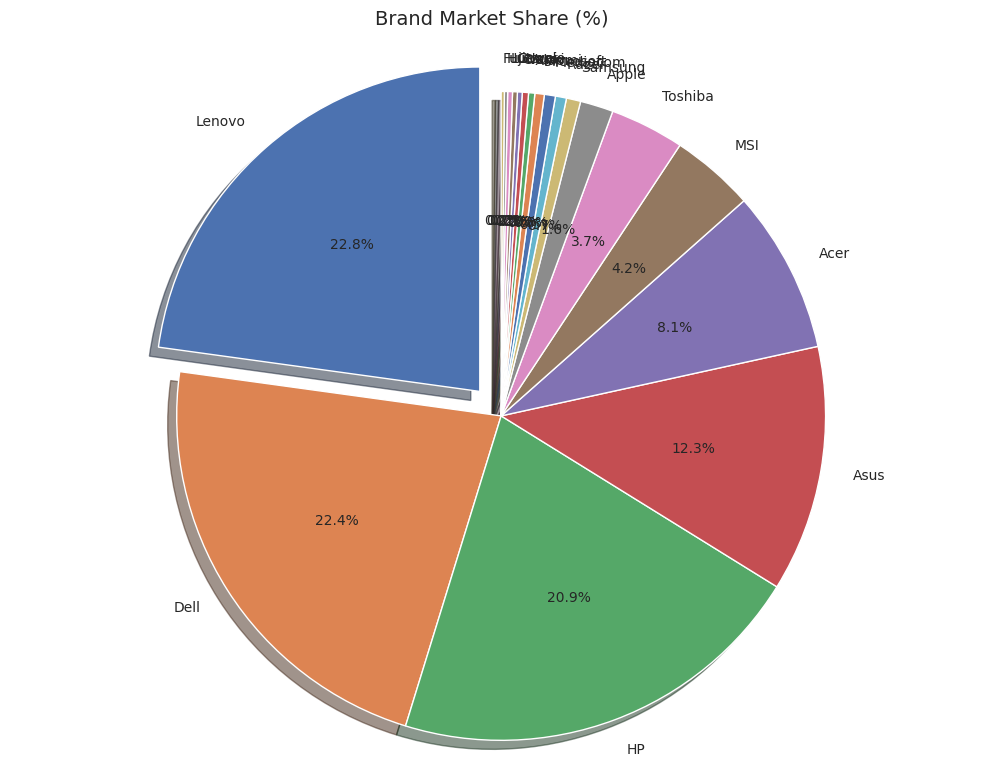

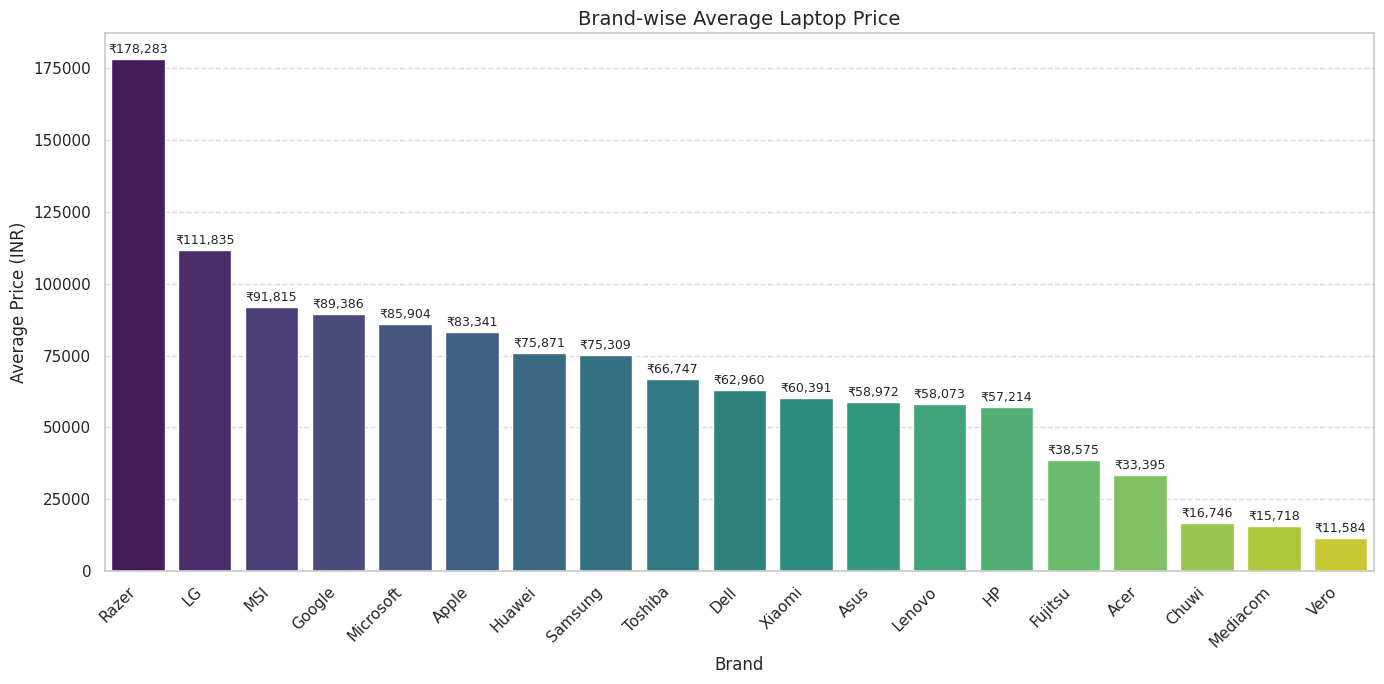

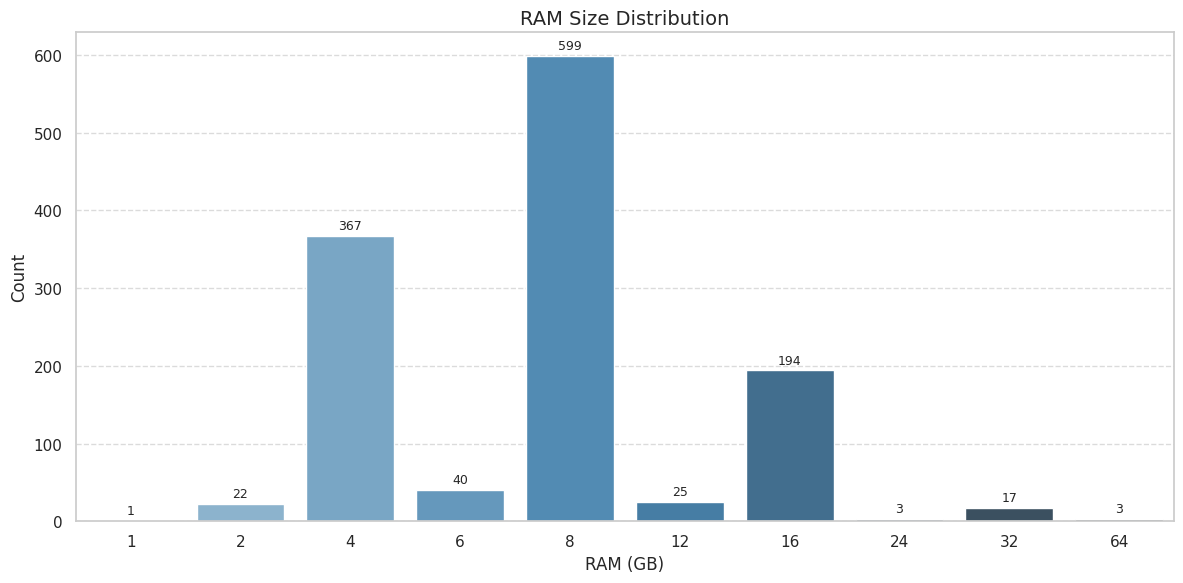

In [18]:
# 3.2 Brand Analysis
# Brand Market Share
plt.figure(figsize=(10, 8))
brand_counts = df_clean['Company'].value_counts()
brand_percentage = (brand_counts / len(df_clean) * 100).round(2)
explode = [0.1 if i == brand_percentage.idxmax() else 0 for i in brand_percentage.index]

plt.pie(brand_percentage, labels=brand_percentage.index, autopct='%1.1f%%', 
        startangle=90, shadow=True, explode=explode, 
        textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.axis('equal')
plt.title('Brand Market Share (%)', fontsize=14)
plt.tight_layout()
plt.show()

# Brand-wise Average Price
plt.figure(figsize=(14, 7))
brand_avg_price = df_clean.groupby('Company')['Price'].mean().sort_values(ascending=False)
sns.barplot(x=brand_avg_price.index, y=brand_avg_price.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.title('Brand-wise Average Laptop Price', fontsize=14)

# Add value labels
for i, value in enumerate(brand_avg_price.values.round(0)):
    plt.text(i, value + 1000, f'₹{value:,.0f}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# RAM Analysis
plt.figure(figsize=(12, 6))
ram_count = df_clean['Ram'].value_counts().sort_index()
sns.barplot(x=ram_count.index.astype(str), y=ram_count.values, palette='Blues_d')
plt.xlabel('RAM (GB)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('RAM Size Distribution', fontsize=14)

# Add value labels
for i, value in enumerate(ram_count.values):
    plt.text(i, value + 5, f'{value}', ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.3 Specification Analysis

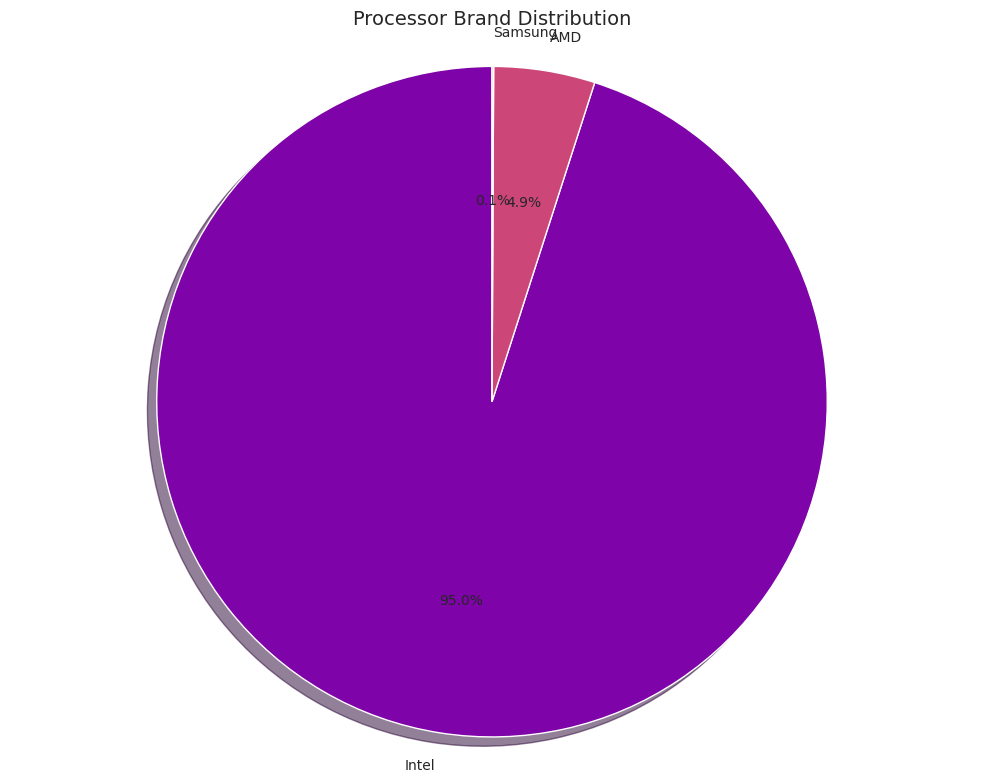

In [19]:
# Processor Brand Analysis
plt.figure(figsize=(10, 8))
proc_brand_count = df_clean['cpu_brand'].value_counts()
plt.pie(proc_brand_count, labels=proc_brand_count.index, autopct='%1.1f%%', 
        startangle=90, shadow=True, textprops={'fontsize': 10}, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}, 
        colors=sns.color_palette("plasma", len(proc_brand_count)))
plt.axis('equal')
plt.title('Processor Brand Distribution', fontsize=14)
plt.tight_layout()
plt.show()